## Setup

In [1]:
import pyvene as pv

In [2]:
import pandas as pd
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)
import torch
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    geom_line,
    geom_point,
    geom_text,
    ggtitle, xlab, ylab, 
    ggsave
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm
from collections import namedtuple

## Load model and data

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = "EleutherAI/pythia-70m" # "EleutherAI/pythia-6.9B"
tokenizer = AutoTokenizer.from_pretrained(model)
tokenizer.pad_token = tokenizer.eos_token
gpt = AutoModelForCausalLM.from_pretrained(
    model,
    revision="main",
    torch_dtype=torch.bfloat16 if model == "EleutherAI/pythia-6.9b" else torch.float32,
).to(device)

In [4]:
from datasets import load_dataset

ds = load_dataset("tasksource/babi_nli", "basic-deduction")

We have a list of 100 names for each gender, and we'll filter for names that are one token in length. We'll further filter for examples the model agrees with our labels for, since some of these names might be ambiguous or the model might not have the expected behaviour. This ensures that baseline IIA is 0.

In [5]:
def get_input_and_label(sample):
    full_sample = sample["hypothesis"] + " " + sample["premise"]
    elements = full_sample.split(" ")
    input_ = " ".join(elements[:-1]) + " "
    label = elements[-1][:-1]
    return input_, label

In [6]:
SINGLE_TOKEN_ANIMALS = ['mouse', 'cat', 'wolf', 'cats']

def filter_dataset(ds):
    filtered_ds = []
    for sample in ds:
        if sample["label"] == 0:
            input_, label = get_input_and_label(sample)
            if label in SINGLE_TOKEN_ANIMALS:
                filtered_ds.append({"sample": input_, "label": label})
    return filtered_ds

In [7]:
filtered_dataset = filter_dataset(ds["train"])

In [8]:
unique_labels = set([sample["label"] for sample in filtered_dataset])

In [9]:
unique_labels

{'cat', 'cats', 'mouse', 'wolf'}

In [10]:
for label in unique_labels:
    tokenized = tokenizer.encode(label)
    print(label)
    print(tokenized)

mouse
[19618]
cats
[38718]
cat
[8076]
wolf
[40995]


In [11]:
Example = namedtuple("Example", ["base", "src", "base_label", "src_label"])

def sample_example(tokenizer):
    base_sample = random.choice(filtered_dataset)
    src_samples = [sample for sample in filtered_dataset if sample["label"] != base_sample["label"]]

    src_sample = random.choice(src_samples)

    base = tokenizer(base_sample["sample"], return_tensors="pt")
    src = tokenizer(src_sample["sample"], return_tensors="pt")
    base_label = tokenizer.encode(base_sample["label"])[0]
    src_label = tokenizer.encode(src_sample["label"])[0]
    return Example(base, src, base_label, src_label)

In [12]:
def generate_n_doable_examples(n, model, tokenizer):
    examples = []
    iterator = tqdm(range(n))
    while len(examples) < n:
        ex = sample_example(tokenizer)
        for k, v in ex.base.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.base[k] = v.to(model.device)
        for k, v in ex.src.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.src[k] = v.to(model.device)
        logits_base = model(**ex.base).logits[0, -1]
        logits_src = model(**ex.src).logits[0, -1]
        if (
            logits_base[ex.base_label] > logits_base[ex.src_label]
            and logits_src[ex.src_label] > logits_src[ex.base_label]
        ):
            examples.append(ex)
            iterator.update(1)
    return examples

In [13]:
# make dataset
total_steps = 100
trainset = generate_n_doable_examples(total_steps, gpt, tokenizer)
evalset = generate_n_doable_examples(50, gpt, tokenizer)

100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


## DAS

This is the usual 1D DAS setup, training on batch size of 1.

In [14]:
def intervention_config(intervention_site, layer, num_dims=1):
    config = pv.IntervenableConfig([
        {
            "layer": layer,
            "component": intervention_site,
            "intervention_type": pv.LowRankRotatedSpaceIntervention,
            "low_rank_dimension": num_dims,
        }
    ])
    return config

In [15]:
# loss function
loss_fct = torch.nn.CrossEntropyLoss()

def calculate_loss(logits, label):
    """Calculate cross entropy between logits and a single target label (can be batched)"""
    shift_labels = label.to(logits.device)
    loss = loss_fct(logits, shift_labels)
    return loss

In [16]:
# intervention settings
stats = []
num_layers = gpt.config.num_hidden_layers

# loop over layers and positions
for layer in range(num_layers):
    for position in range(4):
        print(f"layer: {layer}, position: {position}")

        # set up intervenable model
        config = intervention_config("block_output", layer, 1)
        intervenable = pv.IntervenableModel(config, gpt)
        intervenable.set_device(device)
        intervenable.disable_model_gradients()

        # set up optimizer
        optimizer_params = []
        for k, v in intervenable.interventions.items():
            try:
                optimizer_params.append({"params": v[0].rotate_layer.parameters()})
            except:
                pass
        optimizer = torch.optim.Adam(optimizer_params, lr=1e-3)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps,
        )

        # training loop
        iterator = tqdm(trainset)
        for example in iterator:
            # forward pass
            _, counterfactual_outputs = intervenable(
                example.base,
                [example.src],
                {"sources->base": position},
            )

            # loss
            logits = counterfactual_outputs.logits[:, -1]
            loss = calculate_loss(logits, torch.tensor([example.src_label]).to(device))
            iterator.set_postfix({"loss": f"{loss.item():.3f}"})

            # backward
            loss.backward()
            optimizer.step()
            scheduler.step()

        # eval
        with torch.no_grad():
            iia = 0
            iterator = tqdm(evalset)
            for example in iterator:
                # forward
                _, counterfactual_outputs = intervenable(
                    example.base,
                    [example.src],
                    {"sources->base": position},
                )

                # calculate iia
                logits = counterfactual_outputs.logits[0, -1]
                if logits[example.src_label] > logits[example.base_label]:
                    iia += 1

            # stats
            iia = iia / len(evalset)
            stats.append({"layer": layer, "position": position, "iia": iia})
            print(f"iia: {iia:.3%}")
df = pd.DataFrame(stats)
df.to_csv(f"./tutorial_data/pyvene_gender_das.csv")

layer: 0, position: 0


100%|██████████| 50/50 [00:01<00:00, 30.90it/s]


iia: 4.000%
layer: 0, position: 1


100%|██████████| 50/50 [00:01<00:00, 31.63it/s]


iia: 2.000%
layer: 0, position: 2


100%|██████████| 50/50 [00:01<00:00, 31.41it/s]


iia: 6.000%
layer: 0, position: 3


100%|██████████| 50/50 [00:01<00:00, 25.22it/s]


iia: 4.000%
layer: 1, position: 0


100%|██████████| 50/50 [00:01<00:00, 32.03it/s]


iia: 0.000%
layer: 1, position: 1


100%|██████████| 50/50 [00:01<00:00, 31.82it/s]


iia: 0.000%
layer: 1, position: 2


100%|██████████| 50/50 [00:01<00:00, 32.83it/s]


iia: 4.000%
layer: 1, position: 3


100%|██████████| 50/50 [00:01<00:00, 30.33it/s]


iia: 6.000%
layer: 2, position: 0


100%|██████████| 50/50 [00:01<00:00, 26.76it/s]


iia: 10.000%
layer: 2, position: 1


100%|██████████| 50/50 [00:01<00:00, 31.66it/s]


iia: 6.000%
layer: 2, position: 2


100%|██████████| 50/50 [00:01<00:00, 32.05it/s]


iia: 0.000%
layer: 2, position: 3


100%|██████████| 50/50 [00:01<00:00, 28.63it/s]


iia: 4.000%
layer: 3, position: 0


100%|██████████| 50/50 [00:01<00:00, 26.87it/s]


iia: 8.000%
layer: 3, position: 1


100%|██████████| 50/50 [00:01<00:00, 29.42it/s]


iia: 0.000%
layer: 3, position: 2


100%|██████████| 50/50 [00:01<00:00, 30.12it/s]


iia: 0.000%
layer: 3, position: 3


100%|██████████| 50/50 [00:01<00:00, 30.52it/s]


iia: 4.000%
layer: 4, position: 0


100%|██████████| 50/50 [00:01<00:00, 25.12it/s]


iia: 8.000%
layer: 4, position: 1


100%|██████████| 50/50 [00:01<00:00, 31.28it/s]


iia: 0.000%
layer: 4, position: 2


100%|██████████| 50/50 [00:01<00:00, 31.57it/s]


iia: 0.000%
layer: 4, position: 3


100%|██████████| 50/50 [00:01<00:00, 30.38it/s]


iia: 0.000%
layer: 5, position: 0


100%|██████████| 50/50 [00:01<00:00, 25.06it/s]


iia: 0.000%
layer: 5, position: 1


100%|██████████| 50/50 [00:01<00:00, 31.98it/s]


iia: 0.000%
layer: 5, position: 2


100%|██████████| 50/50 [00:01<00:00, 28.55it/s]


iia: 0.000%
layer: 5, position: 3


100%|██████████| 50/50 [00:01<00:00, 33.25it/s]

iia: 0.000%


And this is the plot of IIA. In layers 2 and 3 it seems the gender is represented across positions 1-3, and entirely in position 3 in later layers.

/Users/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 3 in image.
/Users/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_gender_das.pdf


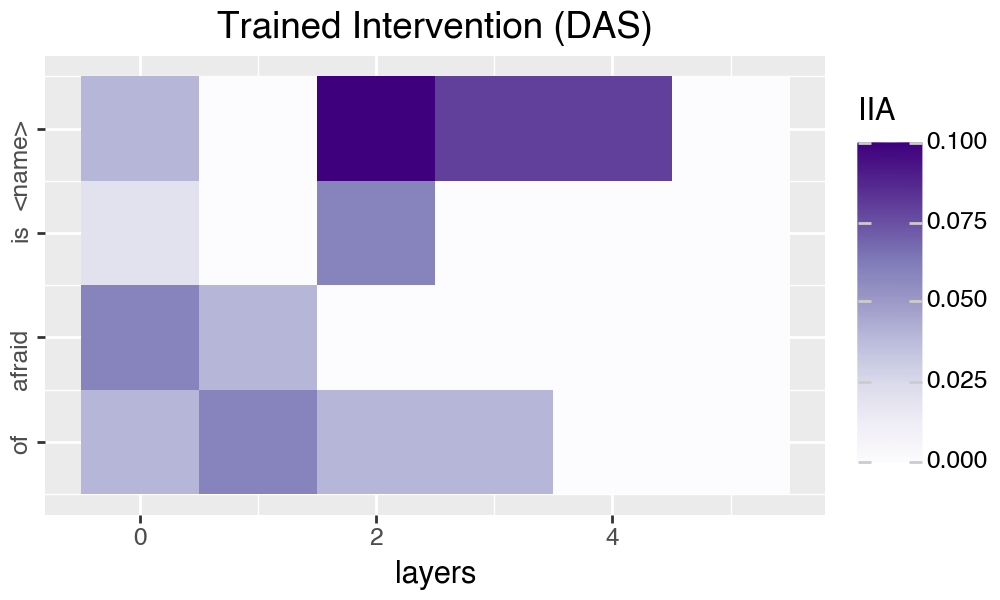

In [17]:
df = pd.read_csv(f"./tutorial_data/pyvene_gender_das.csv")
df["layer"] = df["layer"].astype(int)
df["pos"] = df["position"].astype(int)
df["IIA"] = df["iia"].astype(float)

custom_labels = ["<name>", "is", "afraid", "of", "<animal>"]
breaks = [0, 1, 2, 3, 4]

plot = (
    ggplot(df, aes(x="layer", y="pos"))    
    + geom_tile(aes(fill="IIA"))
    + scale_fill_cmap("Purples") + xlab("layers")
    + scale_y_reverse(
        limits = (-0.5, 3.5), 
        breaks=breaks, labels=custom_labels) 
    + theme(figure_size=(5, 3)) + ylab("") 
    + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
    + ggtitle("Trained Intervention (DAS)")
)
ggsave(
    plot, filename=f"./tutorial_data/pyvene_gender_das.pdf", dpi=200
)
display(plot)

## Probing

We'll define a dummy intervention `CollectActivation` to collect activations and train a simple probe.

In [18]:
def probing_config(intervention_site, layer):
    """Generate intervention config."""

    # init
    config = pv.IntervenableConfig([{
        "layer": layer,
        "component": intervention_site,
        "intervention_type": pv.CollectIntervention,
    }])
    return config

This is the training loop.

In [19]:
# intervention settings
stats = []
num_layers = gpt.config.num_hidden_layers

label_mapping = {38718: 0, 40995: 1, 19618: 2, 8076: 3}

# loop over layers and positions
with torch.no_grad():
    for layer in range(num_layers):
        for position in range(4):
            print(f"layer: {layer}, position: {position}")

            # set up intervenable model
            config = probing_config("block_output", layer)
            intervenable = pv.IntervenableModel(config, gpt)
            intervenable.set_device(device)
            intervenable.disable_model_gradients()

            # training loop
            activations, labels = [], []
            iterator = tqdm(trainset)
            for example in iterator:
                # forward pass
                base_outputs, _ = intervenable(
                    example.base,
                    unit_locations={"base": position},
                )
                base_activations = base_outputs[1][0]

                src_outputs, _ = intervenable(
                    example.src,
                    unit_locations={"base": position},
                )
                src_activations = src_outputs[1][0]
                
                # collect activation
                activations.extend(
                    [base_activations.detach()[0].cpu().numpy(), src_activations.detach()[0].cpu().numpy()]
                )
                labels.extend([example.base_label, example.src_label])
            labels = [label_mapping[tuple(label) if isinstance(label, list) else label] for label in labels]
            
            # train logistic regression
            lr = LogisticRegression(random_state=42, max_iter=1000).fit(
                activations, labels
            )

            # eval
            activations, labels = [], []
            iterator = tqdm(evalset)
            for example in iterator:
                # forward pass
                base_outputs, _ = intervenable(
                    example.base,
                    unit_locations={"base": position},
                )
                base_activations = base_outputs[1][0]

                src_outputs, _ = intervenable(
                    example.src,
                    unit_locations={"base": position},
                )
                src_activations = src_outputs[1][0]
                
                # collect activation
                activations.extend(
                    [base_activations.detach()[0].cpu().numpy(), src_activations.detach()[0].cpu().numpy()]
                )
                labels.extend([example.base_label, example.src_label])
            labels = [label_mapping[label] for label in labels]

            # stats
            acc = lr.score(activations, labels)
            f1 = f1_score(labels, lr.predict(activations), average="micro")
            stats.append({"layer": layer, "position": position, "acc": acc, "f1": f1})
            print(f"acc: {acc:.3%}, f1: {f1:.3f}")
df = pd.DataFrame(stats)
df.to_csv(f"./tutorial_data/pyvene_gender_probe.csv")

layer: 0, position: 0


100%|██████████| 50/50 [00:01<00:00, 28.31it/s]


acc: 44.000%, f1: 0.440
layer: 0, position: 1


100%|██████████| 50/50 [00:01<00:00, 27.23it/s]


acc: 44.000%, f1: 0.440
layer: 0, position: 2


100%|██████████| 50/50 [00:01<00:00, 28.00it/s]


acc: 44.000%, f1: 0.440
layer: 0, position: 3


100%|██████████| 50/50 [00:01<00:00, 28.49it/s]


acc: 44.000%, f1: 0.440
layer: 1, position: 0


100%|██████████| 50/50 [00:01<00:00, 28.69it/s]


acc: 44.000%, f1: 0.440
layer: 1, position: 1


100%|██████████| 50/50 [00:01<00:00, 27.74it/s]


acc: 44.000%, f1: 0.440
layer: 1, position: 2


100%|██████████| 50/50 [00:01<00:00, 25.64it/s]


acc: 44.000%, f1: 0.440
layer: 1, position: 3


100%|██████████| 50/50 [00:01<00:00, 28.64it/s]


acc: 44.000%, f1: 0.440
layer: 2, position: 0


100%|██████████| 50/50 [00:02<00:00, 24.55it/s]


acc: 44.000%, f1: 0.440
layer: 2, position: 1


100%|██████████| 50/50 [00:01<00:00, 26.72it/s]


acc: 44.000%, f1: 0.440
layer: 2, position: 2


100%|██████████| 50/50 [00:02<00:00, 24.38it/s]


acc: 44.000%, f1: 0.440
layer: 2, position: 3


100%|██████████| 50/50 [00:01<00:00, 27.60it/s]


acc: 44.000%, f1: 0.440
layer: 3, position: 0


100%|██████████| 50/50 [00:01<00:00, 27.81it/s]


acc: 44.000%, f1: 0.440
layer: 3, position: 1


100%|██████████| 50/50 [00:01<00:00, 25.87it/s]


acc: 44.000%, f1: 0.440
layer: 3, position: 2


100%|██████████| 50/50 [00:01<00:00, 28.12it/s]


acc: 44.000%, f1: 0.440
layer: 3, position: 3


100%|██████████| 50/50 [00:01<00:00, 28.29it/s]


acc: 44.000%, f1: 0.440
layer: 4, position: 0


100%|██████████| 50/50 [00:01<00:00, 26.36it/s]


acc: 44.000%, f1: 0.440
layer: 4, position: 1


100%|██████████| 50/50 [00:01<00:00, 27.74it/s]


acc: 44.000%, f1: 0.440
layer: 4, position: 2


100%|██████████| 50/50 [00:01<00:00, 27.90it/s]


acc: 44.000%, f1: 0.440
layer: 4, position: 3


100%|██████████| 50/50 [00:01<00:00, 27.16it/s]


acc: 44.000%, f1: 0.440
layer: 5, position: 0


100%|██████████| 50/50 [00:01<00:00, 28.55it/s]


acc: 44.000%, f1: 0.440
layer: 5, position: 1


100%|██████████| 50/50 [00:01<00:00, 28.83it/s]


acc: 44.000%, f1: 0.440
layer: 5, position: 2


100%|██████████| 50/50 [00:01<00:00, 29.08it/s]


acc: 44.000%, f1: 0.440
layer: 5, position: 3


100%|██████████| 50/50 [00:01<00:00, 26.31it/s]

acc: 44.000%, f1: 0.440


And the probe accuracy plot is below. Note the extremely high accuracy at all positions at and after the name! Early layers at later positions are better but it saturates much before the IIA for DAS. This shows how unreliable probes are for tracing causal effect.

/Users/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 3 in image.
/Users/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_gender_probe.pdf


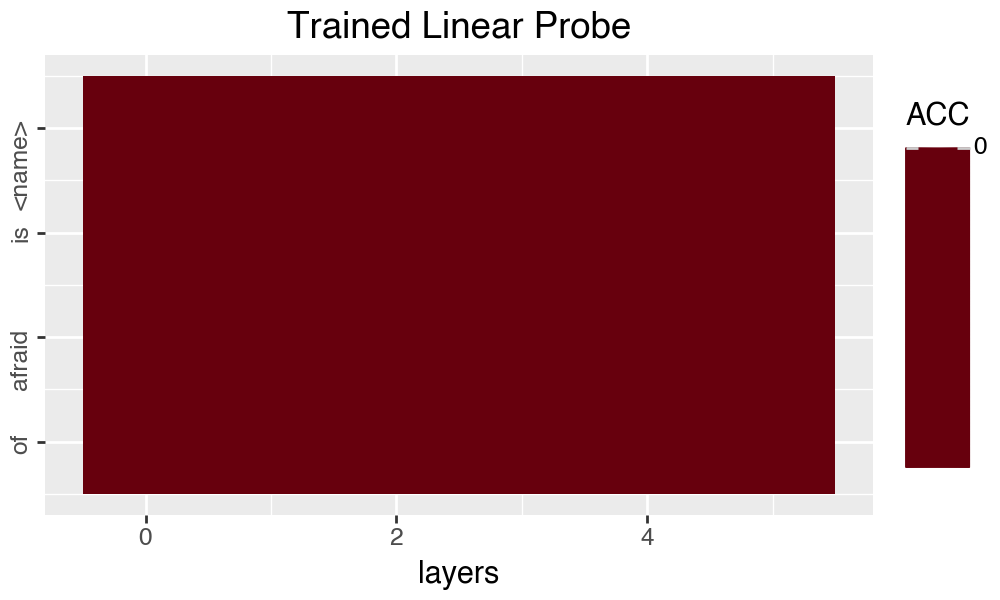

In [20]:
df = pd.read_csv(f"./tutorial_data/pyvene_gender_probe.csv")
df["layer"] = df["layer"].astype(int)
df["pos"] = df["position"].astype(int)
df["ACC"] = df["acc"].astype(float)

custom_labels = ["<name>", "is", "afraid", "of", "<animal>"]
breaks = [0, 1, 2, 3, 4]

plot = (
    ggplot(df, aes(x="layer", y="pos", fill="ACC"))    
    + geom_tile()
    + scale_fill_cmap("Reds") + xlab("layers")
    + scale_y_reverse(
        limits = (-0.5, 3.5), 
        breaks=breaks, labels=custom_labels) 
    + theme(figure_size=(5, 3)) + ylab("") 
    + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
    + ggtitle("Trained Linear Probe")
)
ggsave(
    plot, filename=f"./tutorial_data/pyvene_gender_probe.pdf", dpi=200
)
display(plot)